In [1]:
from pathlib import Path
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import pymaster as nmt
from astropy.io import fits

%matplotlib inline

In [2]:
hp.disable_warnings()

In [3]:
plt.style.use("seaborn-talk")

In [4]:
import pysm3 as pysm
import pysm3.units as u

In [5]:
nside = 2048
lmax = 2048

In [6]:
comp = "IQU"

In [7]:
components = list(enumerate(comp))
components

[(0, 'I'), (1, 'Q'), (2, 'U')]

In [8]:
spectra_components = ["TT", "EE", "BB", "TE"]

change this to True   if you want to  run namaster on notebook 


In [9]:
namaster_on_nb = True

In [10]:
datadir = Path(
    "/global/cscratch1/sd/giuspugl/workstation/FG_extension/extending_gnilc_dust/"
)

# Setting the inputs 
## Dust maps 
- We use the  2015 GNILC intensity map from the 2nd planck release, as it encodes less contamination from CIB with 21.8' resolution https://www.dropbox.com/s/hicocet83z31ob3/COM_CompMap_Dust-GNILC-F353_2048_21p8acm.fits?dl=0

- for Q and U we adopt maps from the 3rd Planck release as they were optimized for polarization studies with 80' reso.  



In [11]:
gnilc_template = "varres"
dust_varresI = datadir / "COM_CompMap_Dust-GNILC-F353_2048_21p8acm.fits"
dust_varresP = (
    datadir / f"COM_CompMap_IQU-thermaldust-gnilc-{gnilc_template}_2048_R3.00.fits"
)

In [12]:
if not dust_varresI.exists():
    !wget -O $dust_varresI https://www.dropbox.com/s/hicocet83z31ob3/COM_CompMap_Dust-GNILC-F353_2048_21p8acm.fits?dl=0

In [13]:
if not dust_varresP.exists():
    !wget -O $dust_varresP http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=COM_CompMap_IQU-thermaldust-gnilc-unires_2048_R3.00.fits

Transform maps to double precision for computations

In [14]:
m_planck_varres, h = hp.read_map(
    dust_varresP, [c + "_STOKES" for c in comp], dtype=np.float64, h=True
)
I_planck_varres, h = hp.read_map(dust_varresI, dtype=np.float64, h=True)

Maps from the two releases are in different units `MJy/sr` the former, and `K_CMB` the latter, we therefore need to perform some conversion to `uK_RJ`. 

In [ ]:
m_planck_varres <<= u.K_CMB
I_planck_varres <<= u.MJy / u.sr
m_planck_varres = m_planck_varres.to(
    "uK_RJ", equivalencies=u.cmb_equivalencies(353 * u.GHz)
)
I_planck_varres = I_planck_varres.to(
    "uK_RJ", equivalencies=u.cmb_equivalencies(353 * u.GHz)
)

then we are ready to combine both maps into one single TQU map. 

In [ ]:
m_planck_varres[0] = I_planck_varres
del I_planck_varres

### GAL080 Planck  mask 

we perform the monopole removal in a region outside  the Galactic plane.  


In [17]:
planck_mask_filename = datadir / "HFI_Mask_GalPlane-apo2_2048_R2.00.fits"

if not planck_mask_filename.exists():
    !wget -O $planck_mask_filename "http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=HFI_Mask_GalPlane-apo2_2048_R2.00.fits"

/global/cscratch1/s     [       <=>          ]   1.50G  14.9MB/s    in 2m 53s  

2022-11-10 07:17:14 (8.86 MB/s) - ‘/global/cscratch1/sd/giuspugl/workstation/FG_extension/extending_gnilc_dust/HFI_Mask_GalPlane-apo2_2048_R2.00.fits’ saved [1610622720]



masking 0.7912631829579672 of the sky


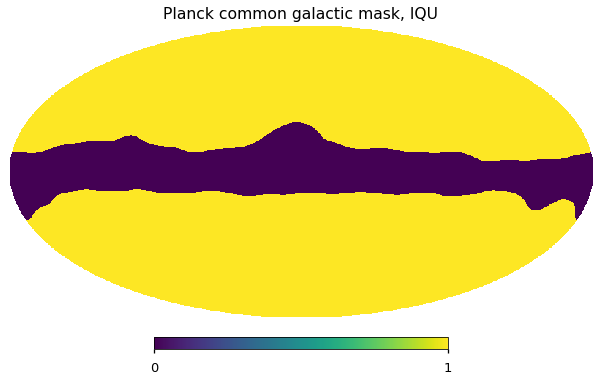

In [18]:
planck_mask = hp.read_map(planck_mask_filename, ["GAL080"])

planck_mask = np.int_(np.ma.masked_not_equal(planck_mask, 0.0).mask)
fsky = planck_mask.sum() / planck_mask.size
print(f"masking {fsky} of the sky")
hp.mollview(planck_mask, title=f"Planck common galactic mask, {comp}")

#### Monopole subtraction 


Section 2.2 of [Planck 2018 XII](https://arxiv.org/pdf/1807.06212.pdf) value reported:  0.13 MJy/sr 

we subtract this term only to the I map for   the pixels outside  the Galactic plane mask.

In [19]:
planck2018_monopole = (0.13 * u.MJy / u.sr).to(
    u.uK_RJ, equivalencies=u.cmb_equivalencies(353 * u.GHz)
)

m_planck_varres[0][planck_mask] -= planck2018_monopole


We estimate how many pixels have I< P after we subtract the monopole 

In [20]:
maskmono = m_planck_varres[0] ** 2 < m_planck_varres[1] ** 2 + m_planck_varres[2] ** 2
print(
    f"{maskmono.sum() } pixels out of { maskmono.size} expected to be NaNs in Log Pol Tens maps "
)

5 pixels out of 50331648 expected to be NaNs in Log Pol Tens maps 


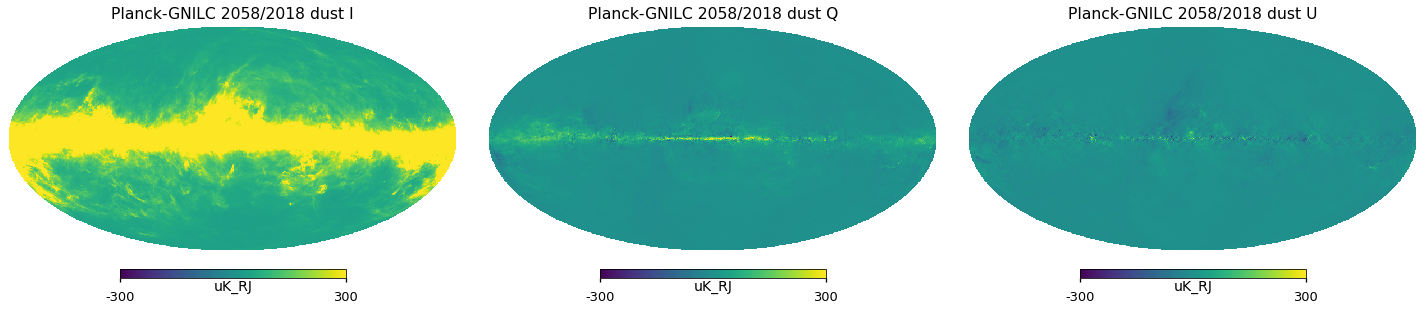

In [21]:
plt.figure(figsize=(20, 5))
for i_pol, pol in components:
    hp.mollview(
        m_planck_varres[i_pol],
        title="Planck-GNILC 2058/2018 dust " + pol,
        sub=131 + i_pol,
        unit=m_planck_varres.unit,
        min=-300,
        max=300,
    )

## Transform maps to Poltens quantities 

In [22]:
def map_to_log_pol_tens(m):
    P = np.sqrt(m[1] ** 2 + m[2] ** 2)
    log_pol_tens = np.empty_like(m)
    log_pol_tens[0] = np.log(m[0] ** 2 - P**2) / 2.0
    log_pol_tens[1:] = m[1:] / P * np.log((m[0] + P) / (m[0] - P)) / 2.0
    return log_pol_tens


def log_pol_tens_to_map(log_pol_tens):
    P = np.sqrt(log_pol_tens[1] ** 2 + log_pol_tens[2] ** 2)
    m = np.empty_like(log_pol_tens)
    exp_i = np.exp(log_pol_tens[0])
    m[0] = exp_i * np.cosh(P)
    m[1:] = log_pol_tens[1:] / P * exp_i * np.sinh(P)
    return m


def sigmoid(x, x0, width, power=4):
    """Sigmoid function given start point and width
    Parameters
    ----------
    x : array
        input x axis
    x0 : float
        value of x where the sigmoid starts (not the center)
    width : float
        width of the transition region in unit of x
    power : float
        tweak the steepness of the curve
    Returns
    -------
    sigmoid : array
        sigmoid, same length of x"""
    return 1.0 / (1 + np.exp(-power * (x - x0 - width / 2) / width))

In [23]:
log_pol_tens_varres = map_to_log_pol_tens(m_planck_varres.value)

/tmp/ipykernel_12806/1566809701.py:4: RuntimeWarning: invalid value encountered in log
  log_pol_tens[0] = np.log(m[0] ** 2 - P ** 2) / 2.0
/tmp/ipykernel_12806/1566809701.py:5: RuntimeWarning: invalid value encountered in log
  log_pol_tens[1:] = m[1:] / P * np.log((m[0] + P) / (m[0] - P)) / 2.0


Checking NaNs  on the Poltens map 

In [24]:
print(
    f"{np.isnan(log_pol_tens_varres[0]).sum()  } pixels out of { maskmono.size} are NaNs in Log Pol Tens maps "
)

5 pixels out of 50331648 are NaNs in Log Pol Tens maps 


In [25]:
for i in range(3):
    log_pol_tens_varres[i, np.isnan(log_pol_tens_varres[i])] = np.nanmedian(
        log_pol_tens_varres[i]
    )

Set all the NaNs to the map median value  


In [26]:
assert np.isnan(log_pol_tens_varres).sum() == 0

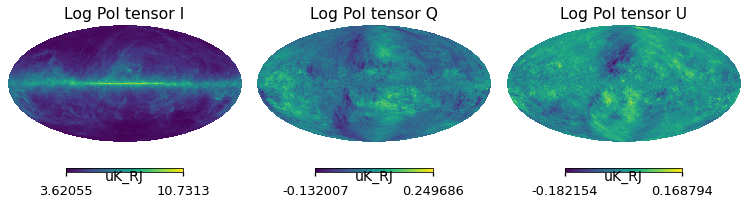

In [27]:
for i_pol, pol in components:
    hp.mollview(
        log_pol_tens_varres[i_pol],
        title="Log Pol tensor " + pol,
        sub=131 + i_pol,
        unit=m_planck_varres.unit,
    )

In [28]:
from scipy.optimize import curve_fit

In [29]:
def model(ell, A, gamma):
    out = A * ell**gamma
    return out

In [30]:
def run_anafast(m, lmax):
    clanaf = hp.anafast(m, lmax=lmax)
    cl = {}
    cl["TT"] = clanaf[0]
    cl["EE"] = clanaf[1]
    cl["BB"] = clanaf[2]
    cl["TE"] = clanaf[3]
    ell = np.arange(lmax + 1)

    cl_norm = ell * (ell + 1) / np.pi / 2
    cl_norm[0] = 1
    return ell, cl_norm, cl


def run_namaster(m, mask, lmax, nlbins):
    """Compute C_ell with NaMaster
    Parameters
    ----------
    m : numpy array
        T only or TQU HEALPix map
    mask : numpy array
        mask, 1D, 0 for masked pixels,
        needs to have same Nside of the input map
    lmax : int
        maximum ell of the spherical harmonics transform
    Returns
    -------
    ell : numpy array
        array of ell from 0 to lmax (length lmax+1)
    cl_norm : numpy array
        ell (ell+1)/2pi factor to turn C_ell into D_ell
        first element is set to 1
    cl : dict of numpy arrays
        dictionary of numpy arrays with all components
        of the spectra, for now only II, EE, BB, no
        cross-spectra
    """

    nside = hp.npix2nside(len(mask))
    # b = nmt.NmtBin.from_nside_linear(nside, 16)
    # leff = b.get_effective_ells()
    binning = nmt.NmtBin(nside=nside, nlb=nlbins, lmax=lmax, is_Dell=False)

    cl = {}

    if len(m) == 3:
        f_0 = nmt.NmtField(mask, [m[0]])
        f_2 = nmt.NmtField(
            mask, m[1:].copy(), purify_b=True
        )  # NaMaster masks the map in-place
        cl_namaster = nmt.compute_full_master(f_2, f_2, binning)
        cl["EE"] = np.concatenate([[0, 0], cl_namaster[0]])
        cl["BB"] = np.concatenate([[0, 0], cl_namaster[3]])
        cl_namaster = nmt.compute_full_master(f_0, f_2, binning)
        cl["TE"] = np.concatenate([[0, 0], cl_namaster[0]])
    elif m.ndim == 1:
        m = m.reshape((1, -1))
        f_0 = nmt.NmtField(mask, [m[0]])

    cl_namaster_I = nmt.compute_full_master(f_0, f_0, binning)

    cl["TT"] = np.concatenate([[0, 0], cl_namaster_I[0]])
    ell = np.concatenate([[0, 1], binning.get_effective_ells()])
    cl_norm = ell * (ell + 1) / np.pi / 2
    cl_norm[0] = 1
    return ell, cl_norm, cl

In [31]:
print("run anafast on full  sky  ")
ell, cl_norm, cl = run_anafast(log_pol_tens_varres, lmax)

run anafast on full  sky  


# (New) employing spectral indices from literature 

- https://arxiv.org/pdf/1801.04945.pdf and https://www.aanda.org/articles/aa/pdf/2016/09/aa28503-16.pdf
- 2 pivotal scales `ell1=110` and `ell2=800 ` 
- non zero TE  spectrum 



/tmp/ipykernel_12806/3409733669.py:2: RuntimeWarning: divide by zero encountered in power
  out = A * ell ** gamma
/tmp/ipykernel_12806/3409733669.py:2: RuntimeWarning: divide by zero encountered in power
  out = A * ell ** gamma
/tmp/ipykernel_12806/3409733669.py:2: RuntimeWarning: divide by zero encountered in power
  out = A * ell ** gamma
/tmp/ipykernel_12806/3409733669.py:2: RuntimeWarning: divide by zero encountered in power
  out = A * ell ** gamma


(1e-07, 0.1)

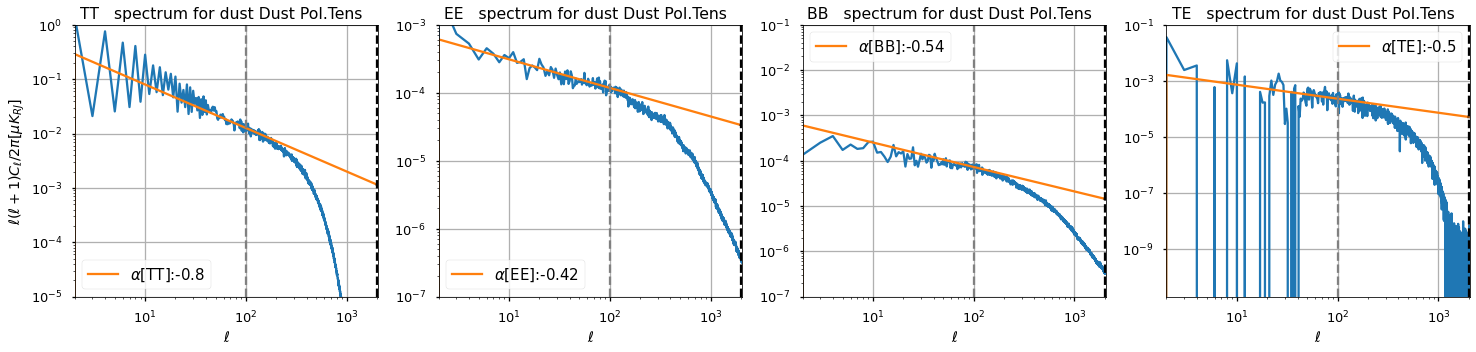

In [32]:
ell_fit_low = {"TT": 50, "EE": 50, "BB": 50, "TE": 50}
ell_fit_high = {"TT": 100, "EE": 100, "BB": 100, "TE": 100}
gamma_fit2 = {"TT": -0.8, "EE": -0.42, "BB": -0.54, "TE": -0.50}
A_fit, gamma_fit, A_fit_std, gamma_fit_std = {}, {}, {}, {}
plt.figure(figsize=(25, 5))
A_fit2 = {}
smallscales = []

ell_pivot = 2000
for ii, pol in enumerate(spectra_components):
    plt.subplot(141 + ii)
    xdata = np.arange(ell_fit_low[pol], ell_fit_high[pol])
    ydata = xdata * (xdata + 1) / np.pi / 2 * cl[pol][xdata]
    (A_fit[pol], gamma_fit[pol]), cov = curve_fit(model, xdata, ydata)
    A_fit2[pol] = np.fabs(A_fit[pol]) * ell_fit_high[pol] ** (
        gamma_fit[pol] - gamma_fit2[pol]
    )
    plt.loglog(ell, ell * (ell + 1) / np.pi / 2 * cl[pol])
    scaling = model(ell[:ell_pivot], A_fit2[pol], gamma_fit2[pol])
    scaling[:2] = 0
    plt.plot(ell[:ell_pivot], scaling, label=r"$\alpha$" + f"[{pol}]:{gamma_fit2[pol]}")
    smallscales.append(scaling)

    plt.axvline(ell_fit_high[pol], linestyle="--", color="gray")
    plt.axvline(ell_pivot, linestyle="--", color="k")
    plt.grid()
    plt.title(f"{pol}   spectrum for dust Dust Pol.Tens  ")

    plt.xlabel(("$\ell$"))
    plt.xlim(2, lmax)
    plt.legend(fontsize=15)

for ii, pol in enumerate(spectra_components):
    # we change the EE and BB power laws
    xdata = np.arange(ell_fit_high[pol], ell.size)
    ydata = xdata * (xdata + 1) / np.pi / 2 * cl[pol][xdata]
    (A_fit[pol], gamma_fit[pol]), cov = curve_fit(model, xdata, ydata)

    plt.subplot(141 + ii)
    if pol == "TE":
        A_fit2[pol] = A_fit2[pol] * ell_pivot ** (gamma_fit2[pol] - gamma_fit2["TE"])
        scaling = model(ell[ell_pivot:], A_fit2[pol], gamma_fit2["TE"])

        plt.plot(
            ell[ell_pivot:],
            scaling,
            linewidth=3,
            alpha=0.4,
            color="k",
        )
        smallscales[ii] = np.concatenate([smallscales[ii], scaling])
    else:
        A_fit2[pol] = A_fit2[pol] * ell_pivot ** (gamma_fit2[pol] - gamma_fit2["TT"])
        scaling = model(ell[ell_pivot:], A_fit2[pol], gamma_fit2["TT"])

        plt.plot(
            ell[ell_pivot:],
            scaling,
            linewidth=3,
            alpha=0.4,
            color="k",
        )
        smallscales[ii] = np.concatenate([smallscales[ii], scaling])

plt.subplot(141)

plt.ylabel("$\ell(\ell+1)C_\ell/2\pi [\mu K_{RJ}]$")
plt.ylim(1e-5, 1e0)
plt.subplot(142)
plt.ylim(1e-7, 1e-3)
plt.subplot(143)
plt.ylim(1e-7, 1e-3)
plt.subplot(143)
plt.ylim(1e-7, 1e-1)

# modulating  intensity small scales 

In [33]:
smooth = hp.smoothing(log_pol_tens_varres[0], fwhm=np.radians(5), lmax=lmax)

In [34]:
b1 = 1.1
b2 = 2
a = 0.1
minmax = lambda m, a, b: a + (b - a) * (m - m.min()) / (m.max() - m.min())
val = 4.5
modulate_amp = (smooth) * 1.0
mskmd = smooth > val

modulate_amp[mskmd] = minmax(smooth[mskmd], a=b1, b=b2)

modulate_amp[~mskmd] = minmax(smooth[~mskmd], a=a, b=b1)

## (New) modulating qu small scales w/ pysm2-like  approach 

- divide the sky into nside=8 patches
- Estimate Namaster E-mode spectra in each pixel    
- Estimate N_patch 
$$ 
N_{patch} = \sqrt{\frac{C_{\ell_*, patch}^{EE }}{A^{EE} \ell_*^{\alpha_E}  }}
$$
- Smooth N_patch map  @10deg


In [35]:
ulogpol = hp.ud_grade(map_in=log_pol_tens_varres, nside_out=256)

In [36]:
small_scales_input_cl = [
    smallscales[ii] * sigmoid(ell, ell_fit_high[pol], ell_fit_high[pol] / 10) / cl_norm
    for ii, pol in enumerate(spectra_components)
]

In [37]:
nsidepatches = 8
patches = np.arange(hp.nside2npix(nsidepatches))
nsideA = hp.get_nside(ulogpol)

upatches = hp.ud_grade(patches, nside_out=nsideA)

In [38]:
import time


def ClEE(mask, mapp):
    map1 = mapp.copy()
    b = nmt.NmtBin.from_nside_linear(hp.get_nside(mask), 35)
    f_2 = nmt.NmtField(mask, map1, purify_b=False)
    cl_22 = nmt.compute_full_master(f_2, f_2, b)
    ell_arr = b.get_effective_ells()
    return (ell_arr, cl_22[0])

In [39]:
""" 
amplitude =np.zeros_like(patches, dtype=float )
for i in patches: 
    start = time.perf_counter()
    
    maskpixs = upatches ==i 
    patch =(maskpixs*ulogpol ) 
    fsky = maskpixs.sum() /maskpixs.size 
    #ell,cl_norm, clp = run_anafast (patch, lmax= 300 )
    #ellb,cl_normb, clp = run_namaster (ulogpol, maskpixs,nlbins=30, lmax= 200 )
    #factors =  np.array([ (np.sqrt((clp [k] [ell_fit_high[k]]/fsky/   smallscales[ik][ell_fit_high[k]] ))) for ik, k in enumerate(spectra_components[:-1] )] ) 
    #factors =  np.array([ (np.sqrt(abs(clp [k] [5]/   small_scales_input_cl[ik][np.int_(ellb[5] )] ))) for ik, k in enumerate(spectra_components[:-1] )] ) 
    #almp =(factors.reshape(3,1) *almSS ) 
    #patch_ss = hp.alm2map(almp, nside=512, lmax=lmax  )
    ell_ ,clp = ClEE (maskpixs,  ulogpol[1:]  ) 
    amplitude[i] = np.sqrt(abs(clp   [3]/   small_scales_input_cl[1][np.int_(ell_[3]  ) ] ) ) 
    end = time.perf_counter()
    if i%100 ==0 :print(i,end-start ) 
#print(factors) 
#hp.gnomview(patch [0], rot=[0,90] , reso=3.75, xsize=320 ) 
#hp.gnomview(ulogpol [0], rot=[0,90] , reso=3.75, xsize=320 )

A2048= hp.ud_grade(amplitude, nside_out=2048)
ampl_smooth =hp.smoothing(A2048, fwhm=np.radians(10), lmax=80 ) 
ampl_smooth = minmax(ampl_smooth, a= ampl_smooth.min() ,b =1.5) 
hp.write_map(datadir/f"pysm2_mod_{gnilc_template}_nside8.fits", ampl_smooth )
"""

' \namplitude =np.zeros_like(patches, dtype=float )\nfor i in patches: \n    start = time.perf_counter()\n    \n    maskpixs = upatches ==i \n    patch =(maskpixs*ulogpol ) \n    fsky = maskpixs.sum() /maskpixs.size \n    #ell,cl_norm, clp = run_anafast (patch, lmax= 300 )\n    #ellb,cl_normb, clp = run_namaster (ulogpol, maskpixs,nlbins=30, lmax= 200 )\n    #factors =  np.array([ (np.sqrt((clp [k] [ell_fit_high[k]]/fsky/   smallscales[ik][ell_fit_high[k]] ))) for ik, k in enumerate(spectra_components[:-1] )] ) \n    #factors =  np.array([ (np.sqrt(abs(clp [k] [5]/   small_scales_input_cl[ik][np.int_(ellb[5] )] ))) for ik, k in enumerate(spectra_components[:-1] )] ) \n    #almp =(factors.reshape(3,1) *almSS ) \n    #patch_ss = hp.alm2map(almp, nside=512, lmax=lmax  )\n    ell_ ,clp = ClEE (maskpixs,  ulogpol[1:]  ) \n    amplitude[i] = np.sqrt(abs(clp   [3]/   small_scales_input_cl[1][np.int_(ell_[3]  ) ] ) ) \n    end = time.perf_counter()\n    if i%100 ==0 :print(i,end-start ) \n#pri

In [40]:
ampl_smooth = hp.read_map(datadir / f"pysm2_mod_{gnilc_template}_nside8.fits")

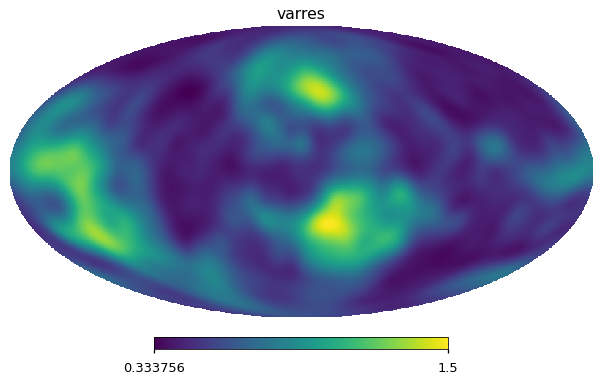

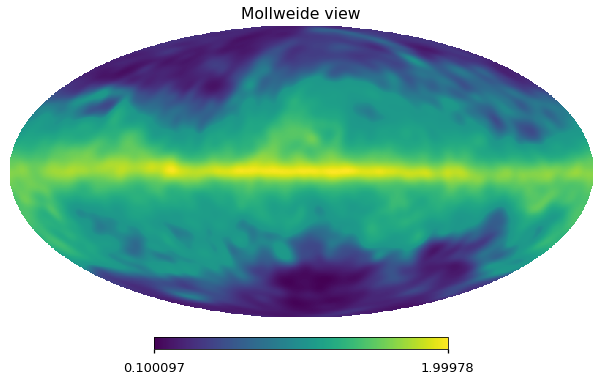

In [41]:
hp.mollview(ampl_smooth, title=gnilc_template, max=1.5)
hp.mollview(modulate_amp)

## (NEW)  small scales included only outside the `GAL097` planck mask 
Employ observed data inside the Gal. Plane 


### Small scale injection 

In [42]:
output_nside = 2048
output_lmax = output_nside
lmax = output_lmax
ell = np.arange(output_lmax + 1)
cl_norm = ell * (ell + 1) / np.pi / 2
cl_norm[:1] = 1

In [43]:
log_ss = hp.synfast(
    small_scales_input_cl,
    lmax=lmax,
    new=True,
    nside=output_nside,
)

In [44]:
log_ss_mod_corrected = log_ss.copy()
log_ss_mod_corrected[0] = log_ss[0] * modulate_amp
log_ss_mod_corrected[1:] = log_ss[1:] * ampl_smooth

In [45]:
np.random.seed(8192)

alm_log_pol_tens_fullsky = hp.map2alm(
    log_pol_tens_varres, lmax=output_lmax, use_pixel_weights=True
)

ii_LS_alm = np.empty_like(alm_log_pol_tens_fullsky)
for ii, pol in enumerate(spectra_components[:-1]):

    sig_func = sigmoid(ell, x0=ell_fit_high[pol], width=ell_fit_high[pol] / 10)

    ii_LS_alm[ii] = hp.almxfl(alm_log_pol_tens_fullsky[ii], (1.0 - sig_func) ** 0.2)


log_ls = hp.alm2map(ii_LS_alm, nside=output_nside)

In [46]:
ii_outmap = log_ls + log_ss_mod_corrected * planck_mask + (1 - planck_mask) * log_ss

In [47]:
galplane_mask = hp.read_map(planck_mask_filename, ["GAL097"])

In [48]:
output_map = log_pol_tens_to_map(ii_outmap)

output_map = galplane_mask * output_map + (1 - galplane_mask) * m_planck_varres.value

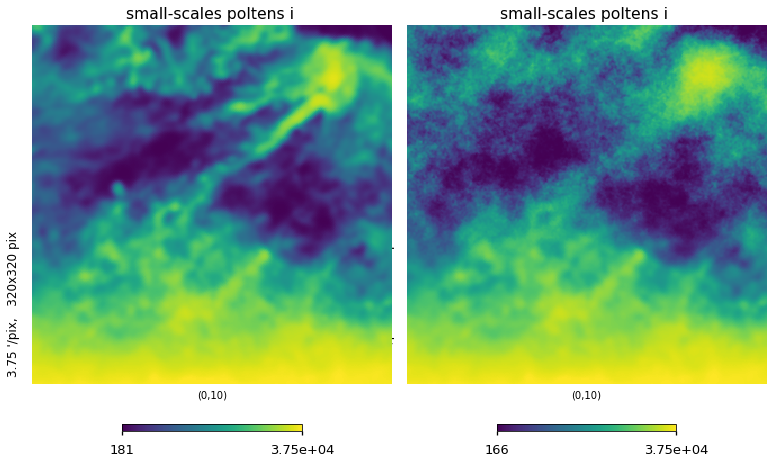

In [49]:
hp.gnomview(
    output_map[0],
    reso=3.75,
    xsize=320,
    norm="hist",
    rot=[0, 10],
    sub=122,
    title="small-scales poltens i ",
)
hp.gnomview(
    m_planck_varres[0],
    reso=3.75,
    xsize=320,
    norm="hist",
    rot=[0, 10],
    sub=121,
    title="small-scales poltens i ",
)

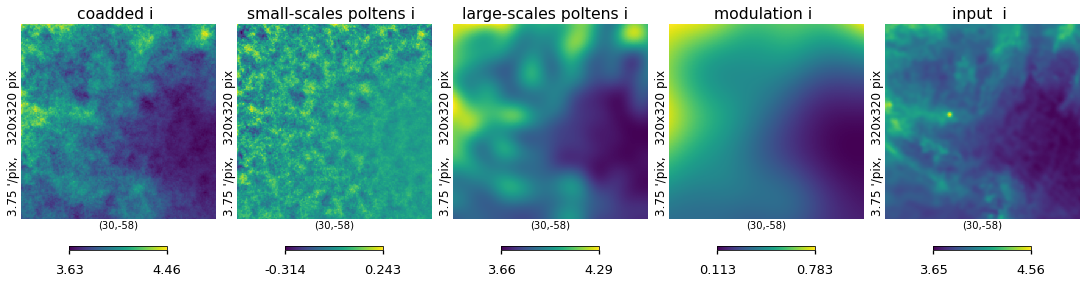

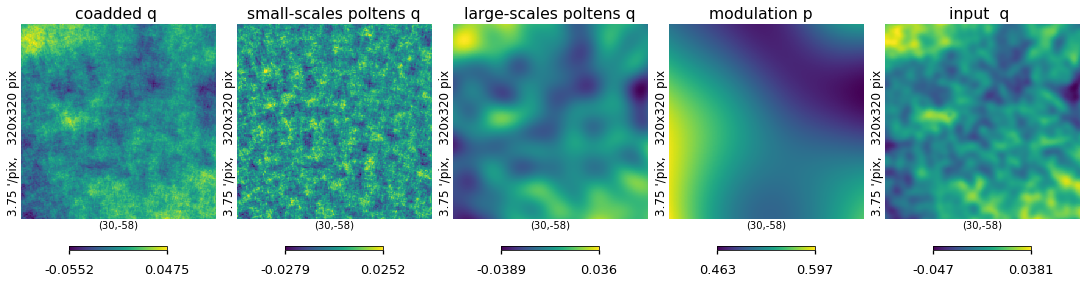

In [50]:
plt.figure(figsize=(15, 5))
hp.gnomview(
    log_ss_mod_corrected[0],
    reso=3.75,
    xsize=320,
    rot=[30, -58],
    sub=152,
    title="small-scales poltens i ",
)
hp.gnomview(
    log_ls[0],
    reso=3.75,
    xsize=320,
    rot=[30, -58],
    sub=153,
    title="large-scales poltens i  ",
)
hp.gnomview(
    ii_outmap[0], reso=3.75, xsize=320, rot=[30, -58], sub=151, title="coadded i "
)
hp.gnomview(
    log_pol_tens_varres[0],
    reso=3.75,
    xsize=320,
    rot=[30, -58],
    sub=155,
    title="input  i ",
)
hp.gnomview(
    modulate_amp, reso=3.75, xsize=320, rot=[30, -58], sub=154, title="modulation i "
)

plt.figure(figsize=(15, 5))
hp.gnomview(
    log_ss_mod_corrected[1],
    reso=3.75,
    xsize=320,
    rot=[30, -58],
    sub=152,
    title="small-scales poltens q",
)
hp.gnomview(
    log_ls[1],
    reso=3.75,
    xsize=320,
    rot=[30, -58],
    sub=153,
    title="large-scales poltens q",
)
hp.gnomview(
    ii_outmap[1], reso=3.75, xsize=320, rot=[30, -58], sub=151, title="coadded q "
)
hp.gnomview(
    log_pol_tens_varres[1],
    reso=3.75,
    xsize=320,
    rot=[30, -58],
    sub=155,
    title="input  q ",
)
hp.gnomview(
    ampl_smooth, reso=3.75, xsize=320, rot=[30, -58], sub=154, title="modulation p  "
)

In [51]:
oldmap = hp.read_map("dataset_pt/realization_0.fits", field=None)

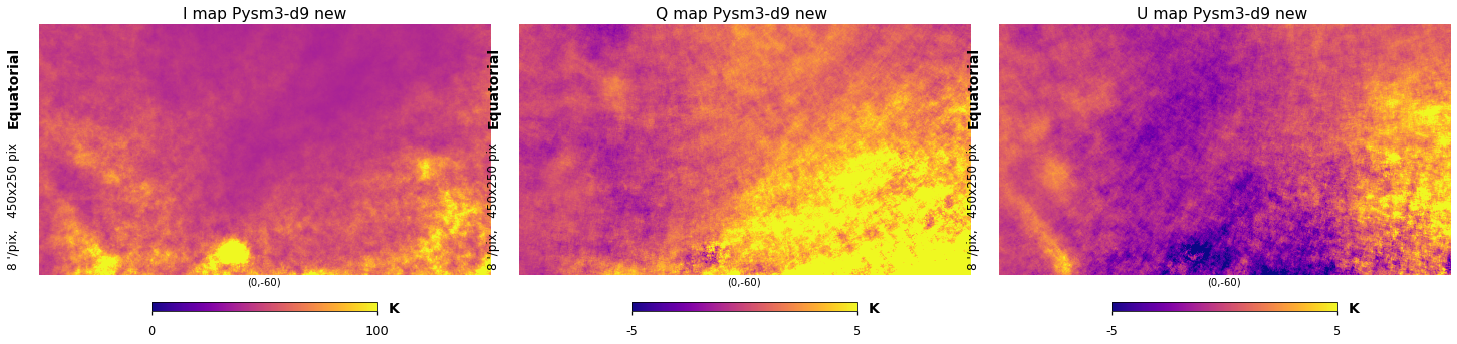

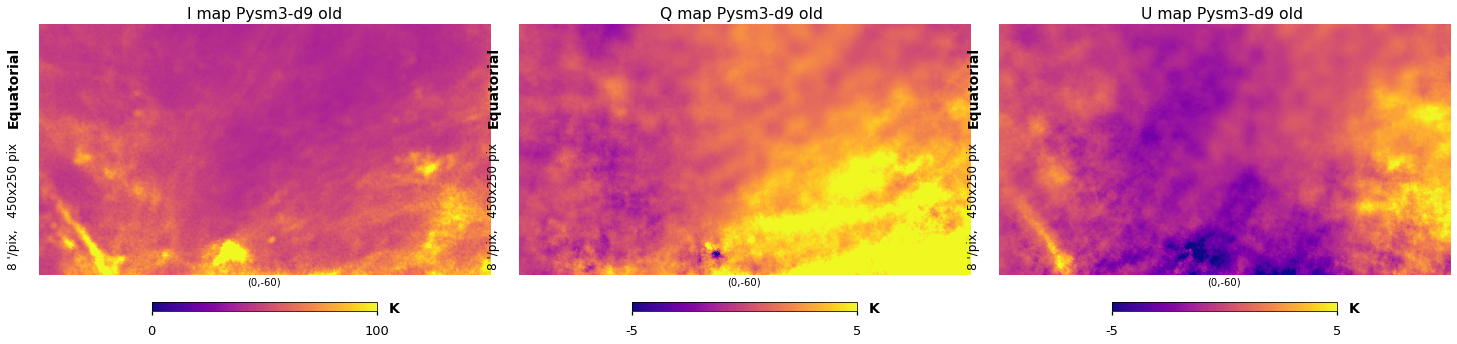

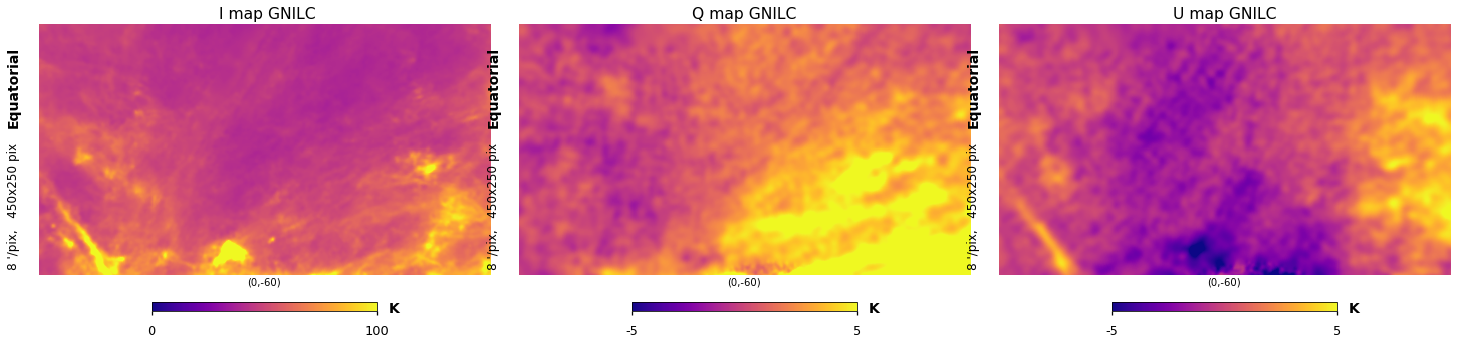

In [52]:
plt.figure(figsize=(20, 5))
hp.gnomview(
    (output_map[0]),
    reso=8,
    xsize=450,
    ysize=250,
    coord=["G", "C"],
    rot=[0, -60],
    cbar=True,
    unit="K",
    title=" I map Pysm3-d9 new ",
    notext=False,
    sub=131,
    min=0,
    max=100,
    cmap="plasma",
)
hp.gnomview(
    (output_map[1]),
    reso=8,
    xsize=450,
    ysize=250,
    coord=["G", "C"],
    rot=[0, -60],
    cbar=True,
    unit="K",
    title="Q map Pysm3-d9 new ",
    notext=False,
    sub=132,
    min=-5,
    max=5,
    cmap="plasma",
)
hp.gnomview(
    (output_map[2]),
    reso=8,
    xsize=450,
    ysize=250,
    coord=["G", "C"],
    rot=[0, -60],
    cbar=True,
    unit="K",
    title="U map Pysm3-d9 new ",
    notext=False,
    sub=133,
    min=-5,
    max=5,
    cmap="plasma",
)

plt.figure(figsize=(20, 5))
hp.gnomview(
    (oldmap[0]),
    reso=8,
    xsize=450,
    ysize=250,
    coord=["G", "C"],
    rot=[0, -60],
    cbar=True,
    unit="K",
    title=" I map Pysm3-d9 old ",
    notext=False,
    sub=131,
    min=0,
    max=100,
    cmap="plasma",
)
hp.gnomview(
    (oldmap[1]),
    reso=8,
    xsize=450,
    ysize=250,
    coord=["G", "C"],
    rot=[0, -60],
    cbar=True,
    unit="K",
    title="Q map Pysm3-d9 old ",
    notext=False,
    sub=132,
    min=-5,
    max=5,
    cmap="plasma",
)
hp.gnomview(
    (oldmap[2]),
    reso=8,
    xsize=450,
    ysize=250,
    coord=["G", "C"],
    rot=[0, -60],
    cbar=True,
    unit="K",
    title="U map Pysm3-d9 old ",
    notext=False,
    sub=133,
    min=-5,
    max=5,
    cmap="plasma",
)
plt.figure(figsize=(20, 5))
hp.gnomview(
    (m_planck_varres[0]),
    reso=8,
    xsize=450,
    ysize=250,
    coord=["G", "C"],
    rot=[0, -60],
    cbar=True,
    unit="K",
    title=" I map GNILC",
    notext=False,
    sub=131,
    min=0,
    max=100,
    cmap="plasma",
)
hp.gnomview(
    (m_planck_varres[1]),
    reso=8,
    xsize=450,
    ysize=250,
    coord=["G", "C"],
    rot=[0, -60],
    cbar=True,
    unit="K",
    title="Q map GNILC",
    notext=False,
    sub=132,
    min=-5,
    max=5,
    cmap="plasma",
)
hp.gnomview(
    (m_planck_varres[2]),
    reso=8,
    xsize=450,
    ysize=250,
    coord=["G", "C"],
    rot=[0, -60],
    cbar=True,
    unit="K",
    title="U map GNILC",
    notext=False,
    sub=133,
    min=-5,
    max=5,
    cmap="plasma",
)

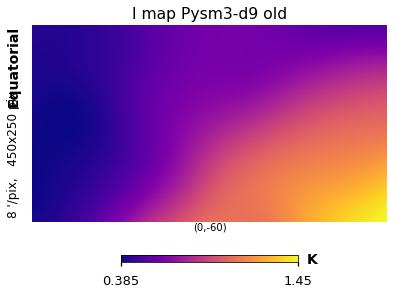

In [53]:
hp.gnomview(
    (ampl_smooth),
    reso=8,
    xsize=450,
    ysize=250,
    coord=["G", "C"],
    rot=[0, -60],
    cbar=True,
    unit="K",
    title=" I map Pysm3-d9 old ",
    notext=False,
    cmap="plasma",
)

In [54]:
del log_ls, ii_LS_alm, log_ss, log_ss_mod_corrected, alm_log_pol_tens_fullsky

In [55]:
"""
hp.write_map(
    datadir / f"dust_gnilc_unir
    es_planck.fits",
    output_map,
    dtype=np.float32,
    overwrite=True,
)
"""

'\nhp.write_map(\n    datadir / f"dust_gnilc_unir\n    es_planck.fits",\n    output_map,\n    dtype=np.float32,\n    overwrite=True,\n)\n'

In [56]:
output_map512 = hp.ud_grade(output_map, nside_out=512)
input_map512 = hp.ud_grade(m_planck_varres.value, nside_out=512)

### UDgrade to accelerate the Namaster computation 

In [57]:
bkmaskfile = datadir / "bk14_mask_gal_n0512.fits"
if not bkmaskfile.exists():
    !wget -O $bkmaskfile http://bicepkeck.org/BK14_datarelease/bk14_mask_gal_n0512.fits
maskbk = hp.read_map(bkmaskfile, verbose=False)
idx = np.where((maskbk < 0) | (~np.isfinite(maskbk)))
maskbk[idx] = 0

In [58]:
aoa = "/global/cscratch1/sd/flauger/S4_misc/weights_aoa_spsat_apo_gal_512.fits"
mask_aoa = hp.read_map(aoa, verbose=False)

In [59]:
planck_mask

array([1, 1, 1, ..., 1, 1, 1])

In [60]:
planck_masks = {
    "GAL099": hp.ud_grade(hp.read_map(planck_mask_filename, ["GAL099"]), nside_out=512),
    "GAL097": hp.ud_grade(hp.read_map(planck_mask_filename, ["GAL097"]), nside_out=512),
    "GAL090": hp.ud_grade(hp.read_map(planck_mask_filename, ["GAL090"]), nside_out=512),
    "GAL080": hp.ud_grade(hp.read_map(planck_mask_filename, ["GAL080"]), nside_out=512),
    "GAL070": hp.ud_grade(hp.read_map(planck_mask_filename, ["GAL070"]), nside_out=512),
    "GAL060": hp.ud_grade(hp.read_map(planck_mask_filename, ["GAL060"]), nside_out=512),
    "GAL040": hp.ud_grade(hp.read_map(planck_mask_filename, ["GAL040"]), nside_out=512),
    "GAL020": hp.ud_grade(hp.read_map(planck_mask_filename, ["GAL020"]), nside_out=512),
}

In [90]:
planck_masks_2048 = {
    "GAL099": hp.read_map(planck_mask_filename, ["GAL099"]),
    "GAL097": hp.read_map(planck_mask_filename, ["GAL097"]),
    "GAL090": hp.read_map(planck_mask_filename, ["GAL090"]),
    "GAL080": hp.read_map(planck_mask_filename, ["GAL080"]),
    "GAL070": hp.read_map(planck_mask_filename, ["GAL070"]),
    "GAL060": hp.read_map(planck_mask_filename, ["GAL060"]),
    "GAL040": hp.read_map(planck_mask_filename, ["GAL040"]),
    "GAL020": hp.read_map(planck_mask_filename, ["GAL020"]),
}

In [61]:
ell, cl_norm, clo = run_anafast(output_map512, lmax=2048)
ell, cl_norm, cli = run_anafast(input_map512, lmax=2048)

In [62]:
colors = plt.cm.cividis(np.linspace(0, 1, len(planck_masks.keys()) + 1))

GAL099
GAL097
GAL090
GAL080
GAL070
GAL060
GAL040
GAL020


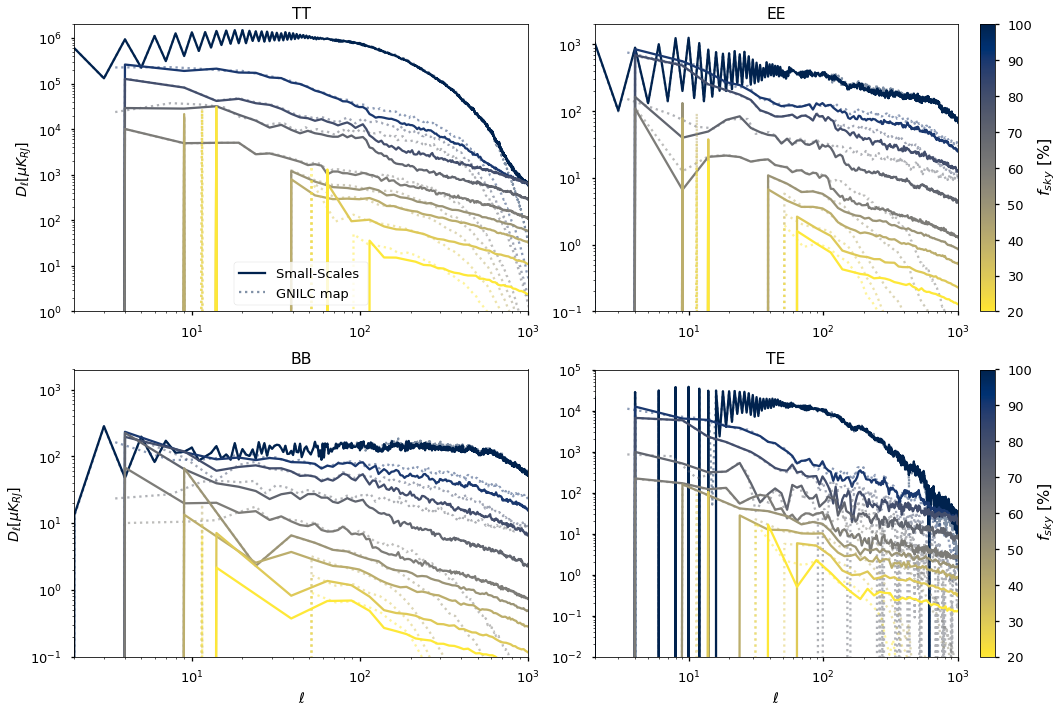

In [63]:
bins = {
    "GAL099": 5,
    "GAL097": 5,
    "GAL090": 5,
    "GAL080": 5,
    "GAL070": 15,
    "GAL060": 15,
    "GAL040": 25,
    "GAL020": 25,
}
plt.figure(figsize=(15, 10))
import os

# for jj, k in enumerate([ "GAL080","GAL070","GAL040" ])  :
for jj, k in enumerate(planck_masks.keys()):
    # fspectra = datadir / f"dust_gnilc_varres_no_monopole_gal{k[3:]}_spectra.npz"
    fspectra = (
        datadir / f"dust_gnilc_{gnilc_template}_no_monopole_gal{k[3:]}_spectra.npz"
    )
    print(k)
    if os.path.exists(fspectra):
        input_ell = np.load(fspectra)["ell"]
        cl_in = {kk: np.load(fspectra)[kk] for kk in spectra_components + ["TE"]}
    else:
        input_ell, cl_norm, cl_in = run_namaster(
            m=input_map512, mask=planck_masks[k], lmax=1300, nlbins=bins[k]
        )
        np.savez(
            fspectra,
            ell=input_ell,
            TT=cl_in["TT"],
            EE=cl_in["EE"],
            BB=cl_in["BB"],
            TE=cl_in["TE"],
        )

    fspectra = (
        datadir / f"dust_gnilc_{gnilc_template}_pysmmod_planck_gal{k[3:]}_spectra.npz"
    )
    if os.path.exists(fspectra):
        output_ell = np.load(fspectra)["ell"]
        cl_out = {kk: np.load(fspectra)[kk] for kk in spectra_components + ["TE"]}
    else:

        # output_ell, cl_norm, cl_out = run_namaster(m = output_map, mask =planck_masks[k] ,lmax=3000 , nlbins = bins[k]  )
        output_ell, cl_norm, cl_out = run_namaster(
            m=output_map, mask=planck_masks_2048[k], lmax=3000, nlbins=bins[k]
        )
        np.savez(
            fspectra,
            ell=output_ell,
            TT=cl_out["TT"],
            EE=cl_out["EE"],
            BB=cl_out["BB"],
            TE=cl_out["TE"],
        )

    for ii, pol in enumerate(["TT", "EE", "BB", "TE"]):
        plt.subplot(2, 2, ii + 1)
        # if jj == 0 :
        #    plt.title(pol)
        #    plt.loglog( ell,  ell**2 *(clo [pol]), label='Small-Scales ' ,color=colors[0] ,)
        #    plt.loglog( ell,  ell**2 *(cli [pol]),':',   label='GNILC map ',color=colors[0] ,alpha=.5)
        plt.loglog(output_ell, output_ell**2 * (cl_out[pol]), color=colors[jj])
        # ,label =f"{k}")
        plt.loglog(
            input_ell,
            input_ell**2 * (cl_in[pol]),
            ":",
            color=colors[jj + 1],
            alpha=0.5,
        )

plt.subplot(221)
plt.legend()
plt.ylabel("$ D_\ell  [\mu K_{RJ}]$")
plt.ylim(1e0, 2e6)
plt.xlim(2, 1e3)

plt.subplot(222)
plt.ylim(1e-1, 2e3)
plt.xlim(2, 1e3)
sm = plt.cm.ScalarMappable(
    cmap=plt.cm.cividis_r, norm=plt.Normalize(vmin=20.0, vmax=100)
)
cb = plt.colorbar(sm)
cb.set_label(r" $f_{sky}$ [%]", rotation="90", fontsize=16)
plt.subplot(223)
plt.ylabel("$ D_\ell  [\mu K_{RJ}]$")
plt.xlabel(("$\ell$"))

plt.ylim(1e-1, 2e3)
plt.xlim(2, 1e3)

plt.subplot(224)
plt.ylim(1e-2, 1e5)
plt.xlim(2, 1e3)

plt.xlabel(("$\ell$"))
sm = plt.cm.ScalarMappable(
    cmap=plt.cm.cividis_r, norm=plt.Normalize(vmin=20.0, vmax=100)
)
cb = plt.colorbar(sm)
cb.set_label(r" $f_{sky}$ [%]", rotation="90", fontsize=16)
plt.tight_layout()

/tmp/ipykernel_12806/3646961144.py:17: RuntimeWarning: invalid value encountered in true_divide
  plt.plot( ell,  (clo ["EE"]/ clo["BB"] ),   color=colors[0] ,alpha=1)
/tmp/ipykernel_12806/3646961144.py:18: RuntimeWarning: invalid value encountered in true_divide
  plt.plot( output_ell,  (cl_out ["EE"]/ cl_out["BB"] ),  color=colors[jj+1] ,alpha=1)
/tmp/ipykernel_12806/3646961144.py:18: RuntimeWarning: invalid value encountered in true_divide
  plt.plot( output_ell,  (cl_out ["EE"]/ cl_out["BB"] ),  color=colors[jj+1] ,alpha=1)
/tmp/ipykernel_12806/3646961144.py:18: RuntimeWarning: invalid value encountered in true_divide
  plt.plot( output_ell,  (cl_out ["EE"]/ cl_out["BB"] ),  color=colors[jj+1] ,alpha=1)
/tmp/ipykernel_12806/3646961144.py:18: RuntimeWarning: invalid value encountered in true_divide
  plt.plot( output_ell,  (cl_out ["EE"]/ cl_out["BB"] ),  color=colors[jj+1] ,alpha=1)
/tmp/ipykernel_12806/3646961144.py:18: RuntimeWarning: invalid value encountered in true_divide
  pl

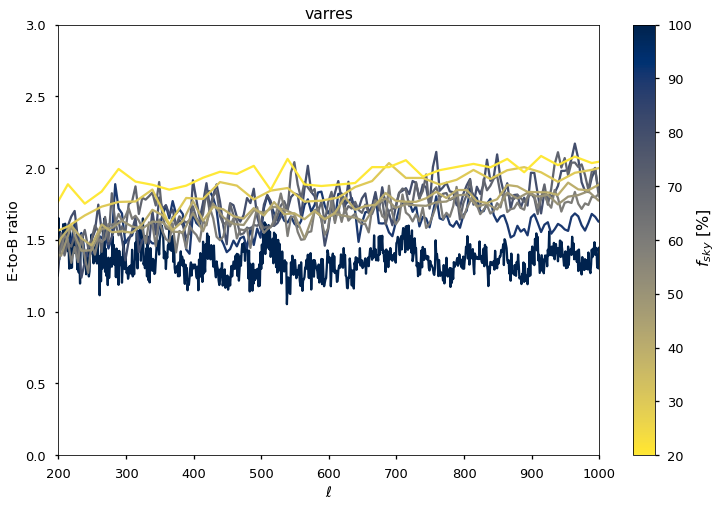

In [64]:
# plt.figure(figsize=(15,10 ))
import os

for jj, k in enumerate(planck_masks.keys()):

    fspectra = datadir / f"dust_gnilc_varres_pysmmod_planck_gal{k[3:]}_spectra.npz"
    if os.path.exists(fspectra):
        #        print("read Namaster spectra  ")
        output_ell = np.load(fspectra)["ell"]
        cl_out = {kk: np.load(fspectra)[kk] for kk in spectra_components + ["TE"]}
    else:
        #        print("computing spectra")

        output_ell, cl_norm, cl_out = run_namaster(
            m=output_map512, mask=planck_masks[k], lmax=1300, nlbins=bins[k]
        )
        np.savez(
            fspectra,
            ell=output_ell,
            TT=cl_out["TT"],
            EE=cl_out["EE"],
            BB=cl_out["BB"],
            TE=cl_out["TE"],
        )

    if jj == 0:
        plt.plot(ell, (clo["EE"] / clo["BB"]), color=colors[0], alpha=1)
    plt.plot(output_ell, (cl_out["EE"] / cl_out["BB"]), color=colors[jj + 1], alpha=1)

plt.xlim(200, 1e3)
plt.ylim(0, 3)
sm = plt.cm.ScalarMappable(
    cmap=plt.cm.cividis_r, norm=plt.Normalize(vmin=20.0, vmax=100)
)
cb = plt.colorbar(sm)
cb.set_label(r" $f_{sky}$ [%]", rotation="90", fontsize=16)
plt.xlabel(("$\ell$"))
plt.ylabel(("E-to-B ratio"))

plt.title(gnilc_template)
plt.tight_layout()

# (New) we further validate E and B spectra  also within the BK and Southern Hole patches

In [77]:
def ClBB(mask, mapp):
    map1 = mapp.copy()
    b = nmt.NmtBin.from_nside_linear(hp.get_nside(mask), 35)
    f_2 = nmt.NmtField(mask, map1, purify_b=True)
    cl_22 = nmt.compute_full_master(f_2, f_2, b)
    ell_arr = b.get_effective_ells()
    return (ell_arr, cl_22[3], cl_22[0])

In [78]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc

In [80]:
i_dic = {}
(ells, clBB_i, clEE_i) = ClBB(mask_aoa, input_map512[1:, :])

i_dic["proposed_S4"] = [clBB_i, clEE_i]
(ells, clBB_i, clEE_i) = ClBB(maskbk, input_map512[1:, :])
i_dic["southern_hole"] = [clBB_i, clEE_i]

In [82]:
o_dic = {}

(oells, clBB_o, clEE_o) = ClBB(mask_aoa, output_map512[1:, :])
o_dic["proposed_S4"] = [clBB_o, clEE_o]
(oells, clBB_o, clEE_o) = ClBB(maskbk, output_map512[1:, :])
o_dic["southern_hole"] = [clBB_o, clEE_o]

In [83]:
bk = (np.sqrt(4.4) * u.uK_CMB).to(
    "uK_RJ", equivalencies=u.cmb_equivalencies(353 * u.GHz)
)

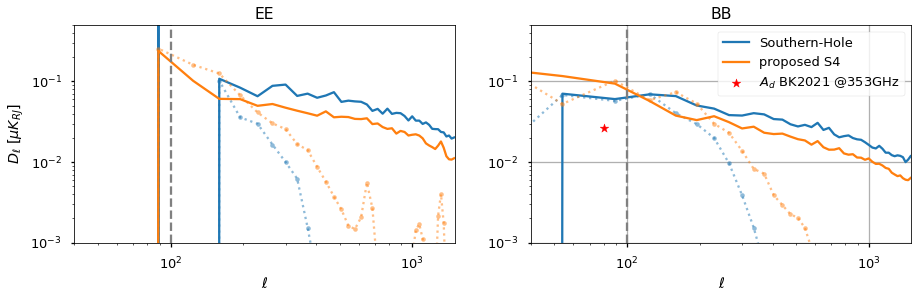

In [84]:
plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.title("EE")
plt.ylabel("$ D_\ell\,\,  [\mu K_{RJ}]$")
plt.xlabel(("$\ell$"))

plt.plot(
    ells,
    ells * (ells + 1.0) * i_dic["southern_hole"][1] / (2.0 * np.pi),
    ".",
    alpha=0.5,
    color="C0",
    linestyle=":",
)
plt.plot(
    oells,
    oells * (oells + 1.0) * o_dic["southern_hole"][1] / (2.0 * np.pi),
    label="BK",
    color="C0",
)
plt.plot(
    ells,
    ells * (ells + 1.0) * i_dic["proposed_S4"][1] / (2.0 * np.pi),
    ".",
    alpha=0.5,
    color="C1",
    linestyle=":",
)
plt.plot(
    oells,
    oells * (oells + 1.0) * o_dic["proposed_S4"][1] / (2.0 * np.pi),
    label="Southern-Hole",
    color="C1",
)
plt.loglog()
plt.ylim(1e-3, 5e-1)
plt.xlim(40, 1.5e3)
plt.axvline(ell_fit_high[pol], linestyle="--", color="gray")
plt.axvline(ell_pivot, linestyle="--", color="k")
plt.subplot(122)
plt.title("BB")
plt.xlabel(("$\ell$"))
plt.plot(
    ells,
    ells * (ells + 1.0) * i_dic["southern_hole"][0] / (2.0 * np.pi),
    ".",
    alpha=0.5,
    color="C0",
    linestyle=":",
)
plt.plot(
    oells,
    oells * (oells + 1.0) * o_dic["southern_hole"][0] / (2.0 * np.pi),
    label="Southern-Hole",
    color="C0",
)
plt.plot(
    ells,
    ells * (ells + 1.0) * i_dic["proposed_S4"][0] / (2.0 * np.pi),
    ".",
    alpha=0.5,
    color="C1",
    linestyle=":",
)
plt.plot(
    oells,
    oells * (oells + 1.0) * o_dic["proposed_S4"][0] / (2.0 * np.pi),
    label="proposed S4",
    color="C1",
)
plt.scatter(
    [80.0], [(bk**2).value], color="r", marker="*", label=r"$A_d$ BK2021 @353GHz"
)
plt.loglog()
plt.ylim(1e-3, 5e-1)
plt.xlim(40, 1.5e3)
plt.axvline(ell_fit_high[pol], linestyle="--", color="gray")
plt.axvline(ell_pivot, linestyle="--", color="k")
plt.legend()
plt.grid()

## Check polarization 

In [85]:
get_polfrac = lambda x: np.sqrt(x[1] ** 2 + x[2] ** 2) / x[0]

In [86]:
Pout = get_polfrac(output_map)
Pin = get_polfrac(m_planck_varres.value)

In [87]:
logpin = np.log10(Pin)
logpout = np.log10(Pout)

In [91]:
planck_masks_bool = {
    k: np.ma.masked_greater(m, 0).mask for k, m in planck_masks_2048.items()
}

GAL099
GAL097
GAL090
GAL080
GAL070
GAL060
GAL040
GAL020


(-3.0, -0.5)

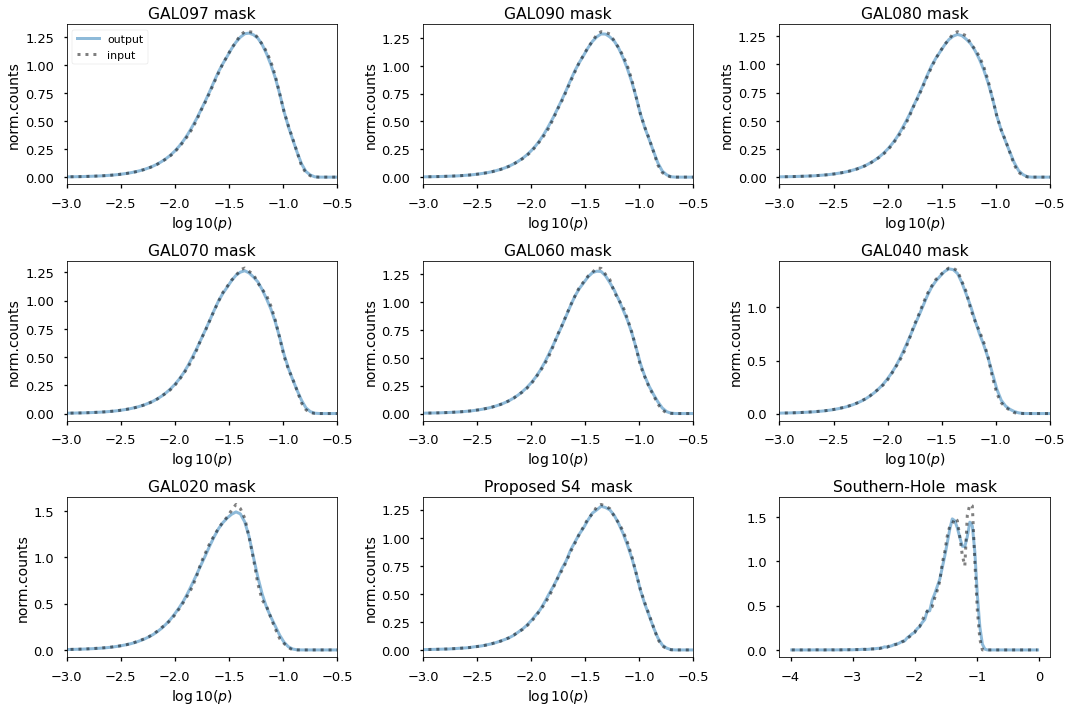

In [94]:
plt.figure(figsize=(15, 10))

for jj, pm in enumerate(planck_masks_bool.items()):
    k = pm[0]
    msk = pm[1]
    print(k)
    if k == "GAL099":
        continue
    plt.subplot(3, 3, jj)

    h, edg = np.histogram(logpout[msk], bins=np.linspace(-4, 0, 100), density=True)
    xb = np.array([(edg[i] + edg[i + 1]) / 2 for i in range(edg.size - 1)])

    plt.plot(xb, h, lw=3, color="C0", alpha=0.5, label="output")
    h, edg = np.histogram(logpin[msk], density=True, bins=np.linspace(-4, 0, 100))
    xb = np.array([(edg[i] + edg[i + 1]) / 2 for i in range(edg.size - 1)])

    plt.plot(xb, h, lw=3, alpha=0.5, color="k", linestyle=":", label="input")
    plt.ylabel("norm.counts", fontsize=14)
    plt.xlabel(r"$\log10( p )$", fontsize=14)
    plt.title(k + " mask")
    plt.xlim(-3, -0.5)

plt.tight_layout()
plt.subplot(331)
plt.legend(fontsize=11, loc="upper left")

plt.subplot(339)

logpin = np.log10(get_polfrac(input_map512))
logpout = np.log10(get_polfrac(output_map512))
h, edg = np.histogram(
    logpout[np.ma.masked_greater(maskbk, 0).mask],
    bins=np.linspace(-4, 0, 100),
    density=True,
)
xb = np.array([(edg[i] + edg[i + 1]) / 2 for i in range(edg.size - 1)])
plt.plot(xb, h, lw=3, color="C0", alpha=0.5, label="output")
h, edg = np.histogram(
    logpin[np.ma.masked_greater(maskbk, 0).mask],
    density=True,
    bins=np.linspace(-4, 0, 100),
)
xb = np.array([(edg[i] + edg[i + 1]) / 2 for i in range(edg.size - 1)])
plt.plot(xb, h, lw=3, alpha=0.5, color="k", linestyle=":", label="input")
plt.title("Southern-Hole  mask")

plt.subplot(338)


h, edg = np.histogram(
    logpout[np.ma.masked_greater(mask_aoa, 0).mask],
    bins=np.linspace(-4, 0, 100),
    density=True,
)
xb = np.array([(edg[i] + edg[i + 1]) / 2 for i in range(edg.size - 1)])
plt.plot(xb, h, lw=3, color="C0", alpha=0.5, label="output")
h, edg = np.histogram(
    logpin[np.ma.masked_greater(mask_aoa, 0).mask],
    density=True,
    bins=np.linspace(-4, 0, 100),
)
xb = np.array([(edg[i] + edg[i + 1]) / 2 for i in range(edg.size - 1)])
plt.plot(xb, h, lw=3, alpha=0.5, color="k", linestyle=":", label="input")
plt.ylabel("norm.counts", fontsize=14)
plt.xlabel(r"$\log10( p )$", fontsize=14)
plt.title("Proposed S4  mask")
plt.xlim(-3, -0.5)